## Problem formulation and Data processing


In [16]:
import pandas as pd
jump_conditions = pd.DataFrame({'jump': range(1,11)
                                })

direction_conditions = pd.DataFrame({'direction':   ['north',   'south',    'east',     'west'  ],
                                     'delta_x_max': [2,         2,          3,          -2      ],
                                     'delta_y_max': [4,         -3,         2,          2       ],
                                     'delta_x_min': [-2,        -2,         2,          -3      ],
                                     'delta_y_min': [3,         -4,         -2,         -2      ]})

In [17]:
from gamspy import Container, Set, Variable, Parameter, Equation, Sum, Model, Sense, Alias

m = Container()
i = Set(m, name='i', description="The i'th jump", records=jump_conditions['jump'])
d = Set(m, name='d', description="jump direction", records=direction_conditions['direction'])

#minmax_dy = Parameter(m, name='minmax_dy', description="(min, max) delta y for each direction", domain=d, records=direction_conditions[['direction','delta_y']])
min_dx = Parameter(m, name='min_dx', description="min delta x for each direction", domain=d, records=direction_conditions[['direction','delta_x_min']])
max_dx = Parameter(m, name='max_dx', description="max delta x for each direction", domain=d, records=direction_conditions[['direction','delta_x_max']])
min_dy = Parameter(m, name='min_dy', description="min delta y for each direction", domain=d, records=direction_conditions[['direction','delta_y_min']])
max_dy = Parameter(m, name='max_dy', description="max delta y for each direction", domain=d, records=direction_conditions[['direction','delta_y_max']])

decisions = Variable(m, name='decisions', type='binary', description="jump decision in all direction at each time", domain=[i,d])

dx = Variable(m, name='dx', description="delta x for each jump", domain=[i,d])
dy = Variable(m, name='dy', description="delta y for each jump", domain=[i,d])

abs_dx = Variable(m, name='abs_dx', description="absolute delta x for each jump", domain=[i])
abs_dy = Variable(m, name='abs_dy', description="absolute delta y for each jump", domain=[i])

## Equation 

In [18]:
# Force the delta to be in bound
midx = Equation(m, name='minimum_delta_x', description="Force the delta to be in bound", domain=[i,d])
midx[i,d] = dx[i,d] >= min_dx[d]*decisions[i,d]

madx = Equation(m, name='maximum_delta_x', description="Force the delta to be in bound", domain=[i,d])
madx[i,d] = dx[i,d] <= max_dx[d]*decisions[i,d]

midy = Equation(m, name='minimum_delta_y', description="Force the delta to be in bound", domain=[i,d])
midy[i,d] = dy[i,d] >= min_dy[d]*decisions[i,d]

mady = Equation(m, name='maximum_delta_y', description="Force the delta to be in bound", domain=[i,d])
mady[i,d] = dy[i,d] <= max_dy[d]*decisions[i,d]

# Absolute value of delta x and delta y
absdx_pos = Equation(m, name='absolute_delta_x_pos', description="Absolute value of delta x positive", domain=i)
absdx_pos[i] = abs_dx[i] >= Sum(d, dx[i,d])

absdx_neg = Equation(m, name='absolute_delta_x_neg', description="Absolute value of delta x negative", domain=i)
absdx_neg[i] = abs_dx[i] >= -Sum(d, dx[i,d])

absdy_pos = Equation(m, name='absolute_delta_y_pos', description="Absolute value of delta y positive", domain=i)
absdy_pos[i] = abs_dy[i] >= Sum(d, dy[i,d])

absdy_neg = Equation(m, name='absolute_delta_y_neg', description="Absolute value of delta y negative", domain=i)
absdy_neg[i] = abs_dy[i] >= -Sum(d, dy[i,d])

# Jump in one direction at each time. (Forces to jump all i times)
cod = Equation(m, name='chose_one_direction', description="Jump in one direction at each time", domain=i)
cod[i] = Sum(d, decisions[i,d]) == 1

# Get to end point.
(start_x, start_y) = (0, 0)
(end_x, end_y) = (13, 17)

eax = Equation(m, name='end_at_x', description="forces to jump to end_x")
eax[...] = start_x + Sum((i,d), dx[i,d]) == end_x
eay = Equation(m, name='end_at_y', description="forces to jump to end_y")
eay[...] = start_y + Sum((i,d), dy[i,d]) == end_y

obj = Sum(i, abs_dx[i] + abs_dy[i])

In [19]:
jump = Model(m, name='jump', sense=Sense.MIN, objective=obj, equations=m.getEquations(), problem="MIP")
jump.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,30,213,141,MIP,CPLEX,0.141


## Primals


In [20]:
dyf = pd.DataFrame(dy.l.records).pivot(index='i', columns='d', values='level')
dxf = pd.DataFrame(dx.l.records).pivot(index='i', columns='d', values='level')
dec_f = pd.DataFrame(decisions.l.records).pivot(index='i', columns='d', values='level')

dyf = dyf.loc[dec_f.sum(axis=1) > 0].reset_index(drop=True)
dxf = dxf.loc[dec_f.sum(axis=1) > 0].reset_index(drop=True)
dec_f = dec_f.loc[dec_f.sum(axis=1) > 0].reset_index(drop=True)

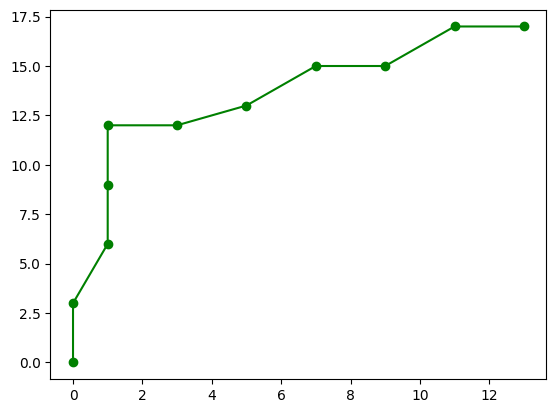

In [21]:
import numpy as np

x_path = np.insert(dxf.sum(axis=1).cumsum().to_numpy(), 0, start_x)
y_path = np.insert(dyf.sum(axis=1).cumsum().to_numpy(), 0, start_y)

import matplotlib.pyplot as plt
plt.plot(x_path, y_path, 'go-')